In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, \
                                        EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [6]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [7]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [8]:
def build_1d_cnn_custom_conv_3_VGG_DO_025_DO_BN(conv_num=1):
    model=Sequential()
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                      activation='relu', input_shape=input_shape)) 
    model.add(Conv1D (kernel_size=3, filters=64, strides=1, padding='same', 
                  activation='relu')) 
#     model.add(BatchNormalization())
#     model.add(MaxPooling1D(pool_size=3, strides=3))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))
        model.add(Conv1D (kernel_size=3, filters=64*(2**int((i+1)/4)), strides=1, padding='same', 
                          activation='relu'))         
#         model.add(BatchNormalization())
        model.add(MaxPooling1D(pool_size=3, strides=3))

    model.add(Flatten())
    
    model.add(Dropout(0.25))
    model.add(Dense(output_size, activation='softmax' ))
    
    return model

In [9]:
for i in range(1, 10):
    model = build_1d_cnn_custom_conv_3_VGG_DO_025_DO_BN(conv_num=i)
    model.summary()
    del model

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 16000, 64)         256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 16000, 64)         12352     
_________________________________________________________________
flatten (Flatten)            (None, 1024000)           0         
_________________________________________________________________
dropout (Dropout)            (None, 1024000)           0         
_________________________________________________________________
dense (Dense)                (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_30 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_31 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_32 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_33 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_34 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_35 (Conv1D)           (None, 5333, 64)          12352     
__________

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_72 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_73 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_74 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_75 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_28 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_76 (Conv1D)           (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_77 (Conv1D)           (None, 5333, 64)          12352     
__________

Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.3031 - acc: 0.2810
Epoch 00001: val_loss improved from inf to 2.06745, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_1_conv_checkpoint/001-2.0674.hdf5
36805/36805 [==============================] - 46s 1ms/sample - loss: 2.3031 - acc: 0.2809 - val_loss: 2.0674 - val_acc: 0.3909
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7940 - acc: 0.4683
Epoch 00002: val_loss improved from 2.06745 to 1.91734, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_1_conv_checkpoint/002-1.9173.hdf5
36805/36805 [==============================] - 44s 1ms/sample - loss: 1.7941 - acc: 0.4683 - val_loss: 1.9173 - val_acc: 0.4130
Epoch 3/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4094 - acc: 0.5915
Epoch 00003: val_loss did not improve fro

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0265 - acc: 0.9976
Epoch 00029: val_loss did not improve from 1.91734
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0265 - acc: 0.9976 - val_loss: 4.8012 - val_acc: 0.3524
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0240 - acc: 0.9973
Epoch 00030: val_loss did not improve from 1.91734
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0240 - acc: 0.9973 - val_loss: 5.1162 - val_acc: 0.3403
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9974
Epoch 00031: val_loss did not improve from 1.91734
36805/36805 [==============================] - 44s 1ms/sample - loss: 0.0243 - acc: 0.9974 - val_loss: 4.8544 - val_acc: 0.3552
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0156 - acc: 0.9990
Epoch 00032: val_loss did not improve from 1.91734
36805/36805 [===========

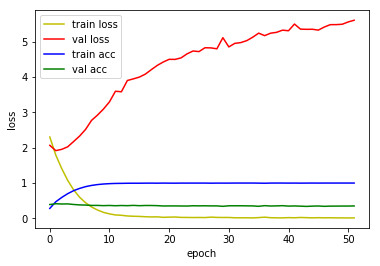

4815/4815 [==============================] - 2s 498us/sample - loss: 1.9555 - acc: 0.3886
Loss: 1.9555140533675037 Accuracy: 0.38857737

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2499 - acc: 0.2900
Epoch 00001: val_loss improved from inf to 1.94697, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_2_conv_checkpoint/001-1.9470.hdf5
36805/36805 [==============================] - 74s 2ms/sample - loss: 2.2498 - acc: 0.2900 - val_loss: 1.9470 - val_acc: 0.3976
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7238 - acc: 0.4816
Epoch 00002: val_loss improved from 1.94697 to 1.68960, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_2_conv_checkpoint/002-1.6896.hdf5
36805/36805 [==============================] - 73s 2ms/sample - loss: 1.7237 - acc: 0.4816 - val_loss: 1.6896 - val_acc: 0.4889
Epoch 3/500
36800/36805 [=======================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0375 - acc: 0.9935
Epoch 00029: val_loss did not improve from 1.67472
36805/36805 [==============================] - 73s 2ms/sample - loss: 0.0375 - acc: 0.9935 - val_loss: 4.6350 - val_acc: 0.4340
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0416 - acc: 0.9921
Epoch 00030: val_loss did not improve from 1.67472
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0416 - acc: 0.9921 - val_loss: 4.7316 - val_acc: 0.4321
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0372 - acc: 0.9932
Epoch 00031: val_loss did not improve from 1.67472
36805/36805 [==============================] - 72s 2ms/sample - loss: 0.0372 - acc: 0.9932 - val_loss: 4.6252 - val_acc: 0.4407
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0366 - acc: 0.9928
Epoch 00032: val_loss did not improve from 1.67472
36805/36805 [===========

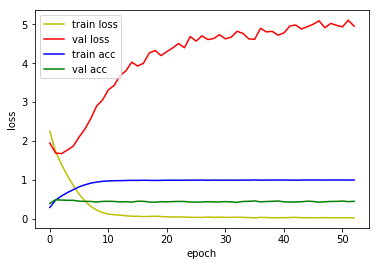

4815/4815 [==============================] - 4s 754us/sample - loss: 1.7554 - acc: 0.4515
Loss: 1.7553632275213953 Accuracy: 0.45150572

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1723 - acc: 0.3115
Epoch 00001: val_loss improved from inf to 1.73407, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_3_conv_checkpoint/001-1.7341.hdf5
36805/36805 [==============================] - 84s 2ms/sample - loss: 2.1721 - acc: 0.3116 - val_loss: 1.7341 - val_acc: 0.4552
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5411 - acc: 0.5260
Epoch 00002: val_loss improved from 1.73407 to 1.48067, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_3_conv_checkpoint/002-1.4807.hdf5
36805/36805 [==============================] - 82s 2ms/sample - loss: 1.5411 - acc: 0.5259 - val_loss: 1.4807 - val_acc: 0.5330
Epoch 3/500
36800/36805 [=======================

Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0599 - acc: 0.9872
Epoch 00029: val_loss did not improve from 1.43181
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0599 - acc: 0.9872 - val_loss: 3.4433 - val_acc: 0.5593
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9880
Epoch 00030: val_loss did not improve from 1.43181
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0578 - acc: 0.9880 - val_loss: 3.5137 - val_acc: 0.5451
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0561 - acc: 0.9882
Epoch 00031: val_loss did not improve from 1.43181
36805/36805 [==============================] - 82s 2ms/sample - loss: 0.0561 - acc: 0.9882 - val_loss: 3.3411 - val_acc: 0.5546
Epoch 32/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0578 - acc: 0.9880
Epoch 00032: val_loss did not improve from 1.43181
36805/36805 [===========

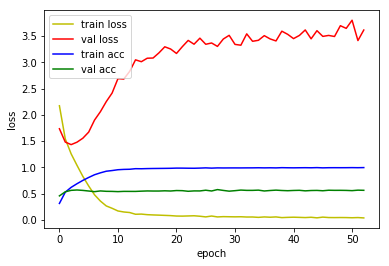

4815/4815 [==============================] - 4s 871us/sample - loss: 1.5044 - acc: 0.5283
Loss: 1.5043999260707313 Accuracy: 0.5283489

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1931 - acc: 0.2911
Epoch 00001: val_loss improved from inf to 1.57875, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_4_conv_checkpoint/001-1.5788.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 2.1930 - acc: 0.2911 - val_loss: 1.5788 - val_acc: 0.4934
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4570 - acc: 0.5406
Epoch 00002: val_loss improved from 1.57875 to 1.35038, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_4_conv_checkpoint/002-1.3504.hdf5
36805/36805 [==============================] - 85s 2ms/sample - loss: 1.4570 - acc: 0.5406 - val_loss: 1.3504 - val_acc: 0.5761
Epoch 3/500
36800/36805 [========================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0708 - acc: 0.9801
Epoch 00028: val_loss did not improve from 1.14708
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0708 - acc: 0.9801 - val_loss: 2.1603 - val_acc: 0.6776
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0720 - acc: 0.9804
Epoch 00029: val_loss did not improve from 1.14708
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0719 - acc: 0.9804 - val_loss: 2.0469 - val_acc: 0.6872
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0610 - acc: 0.9845
Epoch 00030: val_loss did not improve from 1.14708
36805/36805 [==============================] - 84s 2ms/sample - loss: 0.0610 - acc: 0.9845 - val_loss: 2.0368 - val_acc: 0.6874
Epoch 31/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0686 - acc: 0.9813
Epoch 00031: val_loss did not improve from 1.14708
36805/36805 [========================

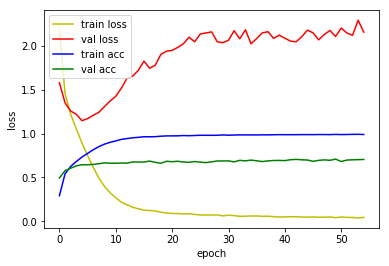

4815/4815 [==============================] - 4s 933us/sample - loss: 1.2181 - acc: 0.6274
Loss: 1.2180704966512426 Accuracy: 0.62741435

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.1287 - acc: 0.3082
Epoch 00001: val_loss improved from inf to 1.47265, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_5_conv_checkpoint/001-1.4726.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 2.1286 - acc: 0.3082 - val_loss: 1.4726 - val_acc: 0.5434
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.4059 - acc: 0.5584
Epoch 00002: val_loss improved from 1.47265 to 1.23049, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_5_conv_checkpoint/002-1.2305.hdf5
36805/36805 [==============================] - 88s 2ms/sample - loss: 1.4059 - acc: 0.5584 - val_loss: 1.2305 - val_acc: 0.6152
Epoch 3/500
36800/36805 [=======================

36800/36805 [============================>.] - ETA: 0s - loss: 0.0746 - acc: 0.9784
Epoch 00027: val_loss did not improve from 0.76615
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0746 - acc: 0.9784 - val_loss: 1.1783 - val_acc: 0.7908
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0747 - acc: 0.9796
Epoch 00028: val_loss did not improve from 0.76615
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0747 - acc: 0.9796 - val_loss: 1.1283 - val_acc: 0.7775
Epoch 29/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0710 - acc: 0.9795
Epoch 00029: val_loss did not improve from 0.76615
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0710 - acc: 0.9795 - val_loss: 1.2161 - val_acc: 0.7887
Epoch 30/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0727 - acc: 0.9784
Epoch 00030: val_loss did not improve from 0.76615
36805/36805 [========================

Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0439 - acc: 0.9892
Epoch 00057: val_loss did not improve from 0.76615
36805/36805 [==============================] - 88s 2ms/sample - loss: 0.0439 - acc: 0.9892 - val_loss: 1.2986 - val_acc: 0.8053

1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_5_conv Model


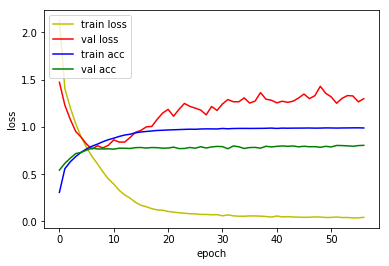

4815/4815 [==============================] - 5s 966us/sample - loss: 0.8578 - acc: 0.7391
Loss: 0.8577612707919421 Accuracy: 0.7391485

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4270 - acc: 0.2028
Epoch 00001: val_loss improved from inf to 1.99875, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_6_conv_checkpoint/001-1.9987.hdf5
36805/36805 [==============================] - 96s 3ms/sample - loss: 2.4270 - acc: 0.2028 - val_loss: 1.9987 - val_acc: 0.3597
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.7298 - acc: 0.4422
Epoch 00002: val_loss improved from 1.99875 to 1.37548, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_6_conv_checkpoint/002-1.3755.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 1.7299 - acc: 0.4422 - val_loss: 1.3755 - val_acc: 0.5495
Epoch 3/500
36800/36805 [========================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1979 - acc: 0.9368
Epoch 00024: val_loss did not improve from 0.42608
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1979 - acc: 0.9368 - val_loss: 0.4418 - val_acc: 0.8987
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1823 - acc: 0.9420
Epoch 00025: val_loss improved from 0.42608 to 0.41430, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_6_conv_checkpoint/025-0.4143.hdf5
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1827 - acc: 0.9419 - val_loss: 0.4143 - val_acc: 0.8928
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1680 - acc: 0.9461
Epoch 00026: val_loss did not improve from 0.41430
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.1680 - acc: 0.9461 - val_loss: 0.5172 - val_acc: 0.8798
Epoch 27/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.0530 - acc: 0.9838
Epoch 00053: val_loss did not improve from 0.41430
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0530 - acc: 0.9838 - val_loss: 0.5941 - val_acc: 0.9075
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0551 - acc: 0.9831
Epoch 00054: val_loss did not improve from 0.41430
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0551 - acc: 0.9831 - val_loss: 0.5285 - val_acc: 0.9075
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0544 - acc: 0.9836
Epoch 00055: val_loss did not improve from 0.41430
36805/36805 [==============================] - 89s 2ms/sample - loss: 0.0545 - acc: 0.9836 - val_loss: 0.5958 - val_acc: 0.9022
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0538 - acc: 0.9835
Epoch 00056: val_loss did not improve from 0.41430
36805/36805 [========================

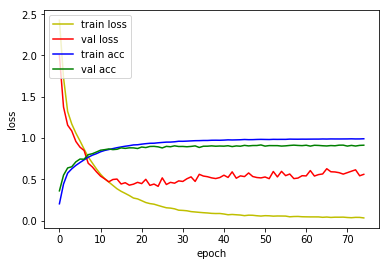

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.4719 - acc: 0.8679
Loss: 0.4719278172911885 Accuracy: 0.86791277

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4367 - acc: 0.1950
Epoch 00001: val_loss improved from inf to 1.83150, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_7_conv_checkpoint/001-1.8315.hdf5
36805/36805 [==============================] - 100s 3ms/sample - loss: 2.4368 - acc: 0.1950 - val_loss: 1.8315 - val_acc: 0.4274
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5478 - acc: 0.4939
Epoch 00002: val_loss improved from 1.83150 to 1.27734, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_7_conv_checkpoint/002-1.2773.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 1.5477 - acc: 0.4939 - val_loss: 1.2773 - val_acc: 0.6014
Epoch 3/500
36800/36805 [========================

Epoch 23/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1666 - acc: 0.9461
Epoch 00023: val_loss improved from 0.22263 to 0.21672, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_7_conv_checkpoint/023-0.2167.hdf5
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1665 - acc: 0.9461 - val_loss: 0.2167 - val_acc: 0.9455
Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1590 - acc: 0.9488
Epoch 00024: val_loss did not improve from 0.21672
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1590 - acc: 0.9488 - val_loss: 0.2187 - val_acc: 0.9418
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1551 - acc: 0.9484
Epoch 00025: val_loss did not improve from 0.21672
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.1551 - acc: 0.9484 - val_loss: 0.2178 - val_acc: 0.9385
Epoch 26/500
36800/36805 [============================>.] - ET

Epoch 52/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0567 - acc: 0.9804
Epoch 00052: val_loss did not improve from 0.19860
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0567 - acc: 0.9804 - val_loss: 0.2413 - val_acc: 0.9443
Epoch 53/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0518 - acc: 0.9819
Epoch 00053: val_loss did not improve from 0.19860
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0517 - acc: 0.9819 - val_loss: 0.2457 - val_acc: 0.9509
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0541 - acc: 0.9816
Epoch 00054: val_loss did not improve from 0.19860
36805/36805 [==============================] - 90s 2ms/sample - loss: 0.0541 - acc: 0.9816 - val_loss: 0.2711 - val_acc: 0.9478
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0497 - acc: 0.9830
Epoch 00055: val_loss did not improve from 0.19860
36805/36805 [===========

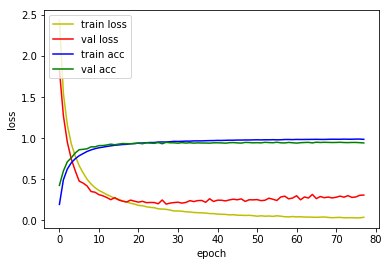

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2490 - acc: 0.9273
Loss: 0.24900241202345022 Accuracy: 0.92731047

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.4519 - acc: 0.1938
Epoch 00001: val_loss improved from inf to 1.79308, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_8_conv_checkpoint/001-1.7931.hdf5
36805/36805 [==============================] - 104s 3ms/sample - loss: 2.4519 - acc: 0.1938 - val_loss: 1.7931 - val_acc: 0.4305
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.5289 - acc: 0.4951
Epoch 00002: val_loss improved from 1.79308 to 1.08161, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_8_conv_checkpoint/002-1.0816.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 1.5290 - acc: 0.4951 - val_loss: 1.0816 - val_acc: 0.6417
Epoch 3/500
36800/36805 [=======================

Epoch 24/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1199 - acc: 0.9598
Epoch 00024: val_loss did not improve from 0.14812
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1198 - acc: 0.9598 - val_loss: 0.1611 - val_acc: 0.9550
Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1180 - acc: 0.9606
Epoch 00025: val_loss did not improve from 0.14812
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1181 - acc: 0.9605 - val_loss: 0.1639 - val_acc: 0.9532
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.1121 - acc: 0.9623
Epoch 00026: val_loss improved from 0.14812 to 0.14049, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_8_conv_checkpoint/026-0.1405.hdf5
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.1122 - acc: 0.9622 - val_loss: 0.1405 - val_acc: 0.9569
Epoch 27/500
36800/36805 [============================>.] - ET

36800/36805 [============================>.] - ETA: 0s - loss: 0.0407 - acc: 0.9867
Epoch 00053: val_loss did not improve from 0.14049
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0406 - acc: 0.9867 - val_loss: 0.1426 - val_acc: 0.9658
Epoch 54/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0413 - acc: 0.9864
Epoch 00054: val_loss did not improve from 0.14049
36805/36805 [==============================] - 92s 2ms/sample - loss: 0.0414 - acc: 0.9864 - val_loss: 0.2014 - val_acc: 0.9522
Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0420 - acc: 0.9857
Epoch 00055: val_loss did not improve from 0.14049
36805/36805 [==============================] - 91s 2ms/sample - loss: 0.0420 - acc: 0.9857 - val_loss: 0.1448 - val_acc: 0.9674
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0359 - acc: 0.9885
Epoch 00056: val_loss did not improve from 0.14049
36805/36805 [========================

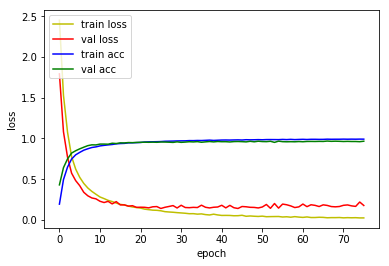

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2102 - acc: 0.9383
Loss: 0.21015337269563664 Accuracy: 0.9383178

Train on 36805 samples, validate on 4293 samples
Epoch 1/500
36800/36805 [============================>.] - ETA: 0s - loss: 2.2723 - acc: 0.2653
Epoch 00001: val_loss improved from inf to 1.61925, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_9_conv_checkpoint/001-1.6193.hdf5
36805/36805 [==============================] - 109s 3ms/sample - loss: 2.2724 - acc: 0.2653 - val_loss: 1.6193 - val_acc: 0.4899
Epoch 2/500
36800/36805 [============================>.] - ETA: 0s - loss: 1.2239 - acc: 0.6012
Epoch 00002: val_loss improved from 1.61925 to 0.73520, saving model to model/checkpoint/1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_9_conv_checkpoint/002-0.7352.hdf5
36805/36805 [==============================] - 93s 3ms/sample - loss: 1.2240 - acc: 0.6012 - val_loss: 0.7352 - val_acc: 0.7584
Epoch 3/500
36800/36805 [========================

Epoch 25/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0757 - acc: 0.9743
Epoch 00025: val_loss did not improve from 0.15513
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0757 - acc: 0.9743 - val_loss: 0.1863 - val_acc: 0.9460
Epoch 26/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0707 - acc: 0.9758
Epoch 00026: val_loss did not improve from 0.15513
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0708 - acc: 0.9757 - val_loss: 0.1856 - val_acc: 0.9509
Epoch 27/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0712 - acc: 0.9753
Epoch 00027: val_loss did not improve from 0.15513
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0712 - acc: 0.9753 - val_loss: 0.1577 - val_acc: 0.9557
Epoch 28/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0616 - acc: 0.9798
Epoch 00028: val_loss did not improve from 0.15513
36805/36805 [===========

Epoch 55/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0212 - acc: 0.9936
Epoch 00055: val_loss did not improve from 0.15513
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0212 - acc: 0.9936 - val_loss: 0.2302 - val_acc: 0.9560
Epoch 56/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0249 - acc: 0.9918
Epoch 00056: val_loss did not improve from 0.15513
36805/36805 [==============================] - 92s 3ms/sample - loss: 0.0249 - acc: 0.9918 - val_loss: 0.1945 - val_acc: 0.9590
Epoch 57/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0272 - acc: 0.9914
Epoch 00057: val_loss did not improve from 0.15513
36805/36805 [==============================] - 93s 3ms/sample - loss: 0.0272 - acc: 0.9914 - val_loss: 0.2246 - val_acc: 0.9588
Epoch 58/500
36800/36805 [============================>.] - ETA: 0s - loss: 0.0194 - acc: 0.9936
Epoch 00058: val_loss did not improve from 0.15513
36805/36805 [===========

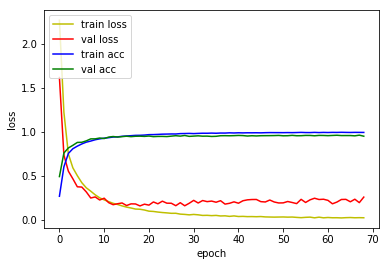

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.2419 - acc: 0.9315
Loss: 0.2418968597057576 Accuracy: 0.9314642



In [10]:
for i in range(1, 10):
    model_name = '1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_{}_conv'.format(i)
    model = build_1d_cnn_custom_conv_3_VGG_DO_025_DO_BN(conv_num=i)
#         model.summary()
    model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
          metrics=['accuracy'])
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    os.makedirs(model_path, exist_ok=True)
    model_filename = model_path+'{epoch:03d}-{val_loss:.4f}.hdf5'
    checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                   verbose=1, save_best_only=True)

    early_stopping = EarlyStopping(monitor='val_loss', patience=50)
    hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=500, 
                     validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                     callbacks = [checkpointer, early_stopping])

    print()
    print(model_name, 'Model')
    fig, ax = plt.subplots()
    ax.plot(hist.history['loss'], 'y', label='train loss')
    ax.plot(hist.history['val_loss'], 'r', label='val loss')
    ax.plot(hist.history['acc'], 'b', label='train acc')
    ax.plot(hist.history['val_acc'], 'g', label='val acc')
    ax.set_xlabel('epoch')
    ax.set_ylabel('loss')
    ax.legend(loc='upper left')
    plt.show()

    png_path = 'visualization/learning_curve/'
    filename = model_name+'.png'
    os.makedirs(png_path, exist_ok=True)
    fig.savefig(png_path+filename, transparent=True)
    
    model.save(model_path+'000_last.hdf5')
    del(model)
    
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + sorted(os.listdir(model_path))[-1]
    model = load_model(model_filename)
    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)
    print()

    del(model)

In [11]:
log_dir = 'log'
os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_025_DO_BN'

with open(path.join(log_dir, base), 'w') as log_file:
    for i in range(1, 10):
        model_name = base+'_{}_conv'.format(i)
        print()
        print(model_name, 'Model')
        model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
        model_filename = model_path + sorted(os.listdir(model_path))[-1]

        model = load_model(model_filename)
        model.summary()

        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)

        del(model)

        log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_1_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_90 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_91 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
flatten_9 (Flatten)          (None, 1024000)           0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 1024000)           0         
_________________________________________________________________
dense_9 (Dense)              (None, 16)                16384016  
Total params: 16,396,624
Trainable params: 16,396,624
Non-trainable params: 0
_________________________________________________________________
4815/4815 [==============================] - 3s 547us/sample - loss: 1.9555 - 

4815/4815 [==============================] - 5s 1ms/sample - loss: 0.8578 - acc: 0.7391
Loss: 0.8577612707919421 Accuracy: 0.7391485

1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_6_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_120 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_121 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_122 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_123 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_46 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_124 (Conv1D)    

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.2102 - acc: 0.9383
Loss: 0.21015337269563664 Accuracy: 0.9383178

1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_9_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_162 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_163 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_164 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_165 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_64 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_166 (Conv1D)   

In [12]:
# log_dir = 'log'
# os.makedirs(log_dir, exist_ok=True)
base = '1D_CNN_custom_conv_3_VGG_DO_025_DO_BN'

# with open(path.join(log_dir, base), 'w') as log_file:
for i in range(3, 10):
    model_name = base+'_{}_conv'.format(i)
    print()
    print(model_name, 'Model')
    model_path = 'model/checkpoint/'+model_name+'_checkpoint/'
    model_filename = model_path + '000_last.hdf5'

    model = load_model(model_filename)
    model.summary()

    [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
    print('Loss:', loss, 'Accuracy:', accuracy)

    del(model)

#         log_file.write('\t'.join([model_name, str(accuracy), str(loss)])+'\n')


1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_3_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_96 (Conv1D)           (None, 16000, 64)         256       
_________________________________________________________________
conv1d_97 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_98 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_99 (Conv1D)           (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_37 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_100 (Conv1D)          (None, 5333, 64)          12352     
_________________________________________________________________
conv1d_101 (Conv1D)     

4815/4815 [==============================] - 6s 1ms/sample - loss: 0.6822 - acc: 0.8883
Loss: 0.6822058703916714 Accuracy: 0.88826585

1D_CNN_custom_conv_3_VGG_DO_025_DO_BN_7_conv Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_132 (Conv1D)          (None, 16000, 64)         256       
_________________________________________________________________
conv1d_133 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_134 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
conv1d_135 (Conv1D)          (None, 16000, 64)         12352     
_________________________________________________________________
max_pooling1d_51 (MaxPooling (None, 5333, 64)          0         
_________________________________________________________________
conv1d_136 (Conv1D)   

4815/4815 [==============================] - 7s 1ms/sample - loss: 0.3566 - acc: 0.9369
Loss: 0.3566372805180247 Accuracy: 0.93686396
